In [ ]:
# default_exp nnpu

In [ ]:
# export
import chainer as ch
from chainer import datasets
import chainer.functions as F
import chainer.links as L
from chainer import training, function, Variable
from chainer.training import extensions
from chainer.backend import cuda
from chainer.utils import type_check

import numpy as np
import matplotlib
import scipy.stats as ss
import matplotlib.pyplot as plt
from IPython.display import Image
from easydict import EasyDict
from copy import deepcopy

# from nnPU_demo.model import ThreeLayerPerceptron

# Define positive and negative distributions

In [ ]:
f1 = ss.norm(loc=0,scale=1)
f0 = ss.norm(loc=-2,scale=1)
alpha = .5

posterior = lambda x: alpha * f1.pdf(x) / (alpha * f1.pdf(x) + (1 - alpha) * f0.pdf(x))

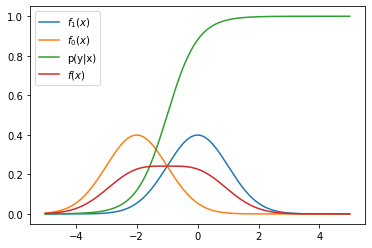

In [ ]:
rng = np.arange(-5,5,.01)
plt.plot(rng,f1.pdf(rng),label=r"$f_1(x)$")
plt.plot(rng,f0.pdf(rng),label=r"$f_0(x)$")
plt.plot(rng,posterior(rng),label=r"p(y|x)")
plt.plot(rng, alpha * f1.pdf(rng) + (1 - alpha) *f0.pdf(rng),label=r"$f(x)$")
plt.legend()
plt.show()

# Create Dataset

In [ ]:
def getData(NPos=1000,NUnlabeled=30000, mixup=False):
#     alpha = np.random.beta(2,2)
    bag = EasyDict()
    bag.alpha = alpha
    positive = f1.rvs(NPos)
    n1U = int(NUnlabeled * alpha)
    n0U = int(NUnlabeled *(1-alpha))
    unlabeled = np.concatenate((f1.rvs(n1U),
                                f0.rvs(n0U)))
    bag.x = np.concatenate((positive, unlabeled))[:,None].astype(np.float32)
    bag.N = bag.x.shape[0]
    bag.y = np.concatenate((np.ones(NPos), np.ones(n1U+n0U)*-1)).astype(np.int32)
    #Add mixup points
    if mixup:
        NMixup = 20000
        betas = np.random.beta(2,2,size=NMixup)[:,None]
        idx1 = np.random.randint(0,bag.x.shape[0],size=NMixup)
        idx2 = np.random.randint(0,bag.x.shape[0],size=NMixup)
        xPrime = np.multiply(bag.x[idx1],betas) + np.multiply((1 - betas),bag.x[idx2])
        yPrime = np.multiply(bag.y[idx1],betas[:,0]) + np.multiply((1 - betas)[:,0],bag.y[idx2])
        bag.x = np.concatenate((bag.x, xPrime)).astype(np.float32)
        bag.y = np.concatenate((bag.y, yPrime)).astype(np.int32)
    return bag

In [ ]:
bag = getData(mixup=False)

In [ ]:
train,test = datasets.split_dataset_random(
    datasets.TupleDataset(bag.x, bag.y), int(bag.N * 0.7))

# Setup Iterator

In [ ]:
args = EasyDict()
args.batchsize=128
args.hdim = 1000

In [ ]:
train_iter = ch.iterators.SerialIterator(train, args.batchsize)
test_iter = ch.iterators.SerialIterator(
    test, args.batchsize, repeat=False, shuffle=False)

# NNPU Loss

In [ ]:
# export
class PULoss(function.Function):
    """wrapper of loss function for PU learning"""

    def __init__(self, prior, loss=(lambda x: F.sigmoid(-x)), gamma=1, beta=0, nnpu=False):
        if not 0 < prior < 1:
            raise NotImplementedError("The class prior should be in (0, 1)")
        self.prior = prior
        self.gamma = gamma
        self.beta = beta
        self.loss_func = loss
        self.nnpu = nnpu
        self.x_in = None
        self.x_out = None
        self.loss = None
        self.positive = 1
        self.unlabeled = -1

    def check_type_forward(self, in_types):
        type_check.expect(in_types.size() == 2)

        x_type, t_type = in_types
        type_check.expect(
            x_type.dtype == np.float32,
            t_type.dtype == np.int32,
            t_type.ndim == 1,
            x_type.shape[0] == t_type.shape[0],
        )

    def forward(self, inputs):
        xp = cuda.get_array_module(*inputs)
        x, t = inputs
        t = t[:, None]
        positive, unlabeled = t == self.positive, t == self.unlabeled
        n_positive, n_unlabeled = max([1., xp.sum(positive)]), max([1., xp.sum(unlabeled)])
        self.x_in = Variable(x)
        y_positive = self.loss_func(self.x_in)
        y_unlabeled = self.loss_func(-self.x_in)
        positive_risk = F.sum(self.prior * positive / n_positive * y_positive)
        negative_risk = F.sum((unlabeled / n_unlabeled - self.prior * positive / n_positive) * y_unlabeled)
#         negative_risk = F.absolute(F.sum((unlabeled / n_unlabeled - self.prior * positive / n_positive) * y_unlabeled))
        objective = positive_risk + negative_risk
        if self.nnpu:
            if negative_risk.data < -self.beta:
                objective = positive_risk - self.beta
                self.x_out = -self.gamma * negative_risk
            else:
                self.x_out = objective
        else:
            self.x_out = objective
        self.loss = xp.array(objective.data, dtype=self.x_out.data.dtype)
        return self.loss,

    def backward(self, inputs, gy):
        self.x_out.backward()
        gx = gy[0].reshape(gy[0].shape + (1,) * (self.x_in.data.ndim - 1)) * self.x_in.grad
        return gx, None


def pu_loss(x, t, prior, loss=(lambda x: F.sigmoid(-x)), nnpu=True):
    """wrapper of loss function for non-negative/unbiased PU learning

        .. math::
            \\begin{array}{lc}
            L_[\\pi E_1[l(f(x))]+\\max(E_X[l(-f(x))]-\\pi E_1[l(-f(x))], \\beta) & {\\rm if nnPU learning}\\\\
            L_[\\pi E_1[l(f(x))]+E_X[l(-f(x))]-\\pi E_1[l(-f(x))] & {\\rm otherwise}
            \\end{array}

    Args:
        x (~chainer.Variable): Input variable.
            The shape of ``x`` should be (:math:`N`, 1).
        t (~chainer.Variable): Target variable for regression.
            The shape of ``t`` should be (:math:`N`, ).
        prior (float): Constant variable for class prior.
        loss (~chainer.function): loss function.
            The loss function should be non-increasing.
        nnpu (bool): Whether use non-negative PU learning or unbiased PU learning.
            In default setting, non-negative PU learning will be used.

    Returns:
        ~chainer.Variable: A variable object holding a scalar array of the
            PU loss.

    See:
        Ryuichi Kiryo, Gang Niu, Marthinus Christoffel du Plessis, and Masashi Sugiyama.
        "Positive-Unlabeled Learning with Non-Negative Risk Estimator."
        Advances in neural information processing systems. 2017.
        du Plessis, Marthinus Christoffel, Gang Niu, and Masashi Sugiyama.
        "Convex formulation for learning from positive and unlabeled data."
        Proceedings of The 32nd International Conference on Machine Learning. 2015.
    """
    return PULoss(prior=prior, loss=loss, nnpu=nnpu)(x, t)

# Model

In [ ]:
# export
def MLP(n_units, n_out):
    layer = ch.Sequential(L.Linear(n_units), L.BatchNormalization(n_units), F.relu)
    model = layer.repeat(4)
    model.append(L.Linear(n_out))

    return model

In [ ]:
model = L.Classifier(
    MLP(args.hdim, 1), lossfun=PULoss(bag.alpha, nnpu=True), accfun=F.accuracy)

# Optimizer

In [ ]:
optimizer = ch.optimizers.Adam(alpha=1e-5).setup(model)
optimizer.add_hook(ch.optimizer.WeightDecay(0.005))

# Updater

In [ ]:
updater = training.StandardUpdater(train_iter, optimizer,device=0)

# Trainer

In [ ]:
trainer = training.Trainer(updater, (100, 'epoch'), out='result')

# Extensions

In [ ]:
trainer.extend(extensions.Evaluator(test_iter, model, device=0))

In [ ]:
trainer.extend(extensions.DumpGraph('main/loss'))

In [ ]:
trainer.extend(extensions.snapshot(), trigger=(20, 'epoch'))

In [ ]:
trainer.extend(extensions.LogReport())

In [ ]:
# Save two plot images to the result dir
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        'epoch', file_name='accuracy.png'))

In [ ]:
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

# Main Loop

In [ ]:
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.218089    0.154396              0              0                         2.35173       
2           0.161296    0.153173              0              0                         5.20668       
3           0.191107    0.151845              0              0                         8.0645        
4           0.170774    0.149887              0              0                         11.8894       
5           0.175894    0.152848              0              0                         15.6054       
6           0.170126    0.15                  0              0                         19.359        
7           0.164306    0.149018              0              0                         23.0032       
8           0.17442     0.146794              0              0                         27.8763       
9           0.17443     0.148552              0              0                      

79          0.17723     0.147894              0              0                         234.554       
80          0.17648     0.151178              0              0                         237.025       
81          0.16738     0.144598              0              0                         241.658       
82          0.164639    0.14467               0              0                         244.081       
83          0.16871     0.144632              0              0                         246.496       
84          0.168132    0.145999              0              0                         248.89        
85          0.168444    0.15051               0              0                         251.282       
86          0.160315    0.146927              0              0                         253.686       
87          0.179621    0.148041              0              0                         256.066       
88          0.165495    0.14711               0              0                    

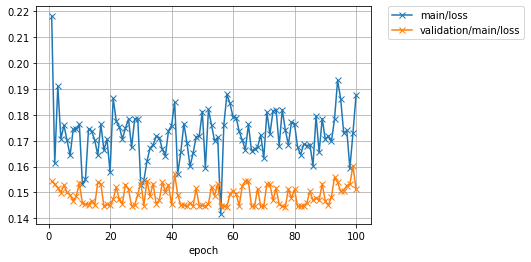

In [ ]:

Image(filename='result/loss.png') 

# Inference

In [ ]:
x = rng[:,None].astype(np.float32)

In [ ]:
predict = model.predictor(cuda.to_gpu(x,device=0)).array

In [ ]:
estimated = cuda.to_cpu(F.sigmoid(predict).array)

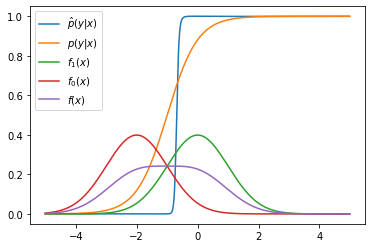

In [ ]:
plt.plot(rng,estimated,label=r"$\hat{p}(y|x)$")
plt.plot(rng, posterior(rng),label=r"$p(y|x)$")
plt.plot(rng, f1.pdf(rng),label=r"$f_1(x)$")
plt.plot(rng, f0.pdf(rng),label=r"$f_0(x)$")
plt.plot(rng, alpha * f1.pdf(rng) + (1 - alpha) *f0.pdf(rng),label=r"$f(x)$")
plt.legend()

In [ ]:
ss.entropy(posterior(rng).flatten(), estimated.flatten())

In [ ]:
# export
def getPosterior(x,y,alpha,args=EasyDict({"batchsize":128,
                                    "hdim":300,
                                    "epochs":250,
                                    "lr":1e-5,
                                    "weightDecayRate":0.005,
                                    })):
    # Data
    train = datasets.TupleDataset(x,y)
    # Iterator
    train_iter = ch.iterators.SerialIterator(train, args.batchsize)
    # model
    model = L.Classifier(MLP(args.hdim, 1,x.shape[1]),
                         lossfun=PULoss(alpha, nnpu=False),
                         accfun=F.accuracy)
    # optimizer
    optimizer = ch.optimizers.Adam(alpha=args.lr).setup(model)
    optimizer.add_hook(ch.optimizer.WeightDecay(args.weightDecayRate))
    updater = training.StandardUpdater(train_iter, optimizer,device=-1)
    trainer = training.Trainer(updater, (args.epochs, 'epoch'), out='result')
    trainer.run()
    return F.sigmoid(model.predictor(x)).array

In [ ]:
getPosterior(bag.x, bag.y,bag.alpha)